### Both methods work for multi-class feature selection.


# Method 1: Use ANOVA F-value to find useful features (for binary / multiclass) classification

See https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide-3.php

In [1]:
import numpy as np
import pandas as pd
from scipy import special
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.feature_selection.univariate_selection import check_X_y, safe_mask, as_float_array, safe_sqr

In [2]:
df = pd.DataFrame(
    {
        'col1':   [11 , 10 , 10 , 100 ,100 ,102 ,51 , 50 , 601 ,600],# col1 is perfect 
        'col2':   [1,   1.1, 1,   11,  10,  10,  5,   5,   5,   5],  # col2 is perfect, excpet class "c" and "d"
        'col3':   [10 , 11 , 100 ,100 ,101 ,100 ,50 , 50 , 51 , 50], # col3 is 10x col4
        'col4':   [1,   1.1, 10,  10,  10.1,10,  5,   5,   5.1, 5],  # col3 is 10x col4
        'col5':   [1,   1,   1.1, 1,   1,   1.1, 1,   1.1, 1.1, 1],  # col5 is useless
        'target': ["a", "a", "a", "b", "b", "b", "c", "c", "d", "d"]
    }
)

In [3]:
fit = SelectKBest(f_classif, k = 2).fit(df.iloc[:,0:5], df.target)

In [4]:
fit.get_support()

array([ True,  True, False, False, False])

- Col 1 should be the best feature, followed by Col 2
- Col 3 and Col 4 should be the same
- Col 5 should be the worst feature

In [5]:
fit.scores_

array([2.26015462e+05, 3.88680198e+02, 2.38430002e+00, 2.38430002e+00,
       5.71428571e-02])

In [6]:
F, pval = f_classif(df.iloc[:,0:5], df.target)

In [7]:
F

array([2.26015462e+05, 3.88680198e+02, 2.38430002e+00, 2.38430002e+00,
       5.71428571e-02])

In [8]:
pval

array([1.51569085e-15, 2.92912877e-07, 1.68061973e-01, 1.68061973e-01,
       9.80413827e-01])

### Dig into the details of `f_classif's f_oneway` implementation

In [9]:
??f_classif

In [10]:
X = df.iloc[:,0:5]
y = df.target
args = [X[safe_mask(X, y == k)] for k in np.unique(y)]

In [11]:
n_classes = len(args)
args = [as_float_array(a) for a in args]
n_samples_per_class = np.array([a.shape[0] for a in args])
n_samples = np.sum(n_samples_per_class)
ss_alldata = sum(safe_sqr(a).sum(axis=0) for a in args)
sums_args = [np.asarray(a.sum(axis=0)) for a in args]
square_of_sums_alldata = sum(sums_args) ** 2
square_of_sums_args = [s ** 2 for s in sums_args]
sstot = ss_alldata - square_of_sums_alldata / float(n_samples)
ssbn = 0.
for k, _ in enumerate(args):
    ssbn += square_of_sums_args[k] / n_samples_per_class[k]
    print(ssbn)
ssbn -= square_of_sums_alldata / float(n_samples)
sswn = sstot - ssbn
dfbn = n_classes - 1
dfwn = n_samples - n_classes
msb = ssbn / float(dfbn)
msw = sswn / float(dfwn)
constant_features_idx = np.where(msw == 0.)[0]

f = msb / msw
# flatten matrix to vector in sparse case
f = np.asarray(f).ravel()
prob = special.fdtrc(dfbn, dfwn, f)

[3.20333333e+02 3.20333333e+00 4.88033333e+03 4.88033333e+01
 3.20333333e+00]
[3.07216667e+04 3.23536667e+02 3.50806667e+04 3.50806667e+02
 6.40666667e+00]
[3.58221667e+04 3.73536667e+02 4.00806667e+04 4.00806667e+02
 8.61166667e+00]
[7.57022667e+05 4.23536667e+02 4.51811667e+04 4.51811667e+02
 1.08166667e+01]


In [12]:
ssbn

array([4.89700167e+05, 1.30855667e+02, 6.36826667e+03, 6.36826667e+01,
       6.66666667e-04])

In [13]:
sswn

array([4.33333333e+00, 6.73333333e-01, 5.34183333e+03, 5.34183333e+01,
       2.33333333e-02])

In [14]:
sstot

array([4.897045e+05, 1.315290e+02, 1.171010e+04, 1.171010e+02,
       2.400000e-02])

# Method 2: phik

Phi_K is a new and practical correlation coefficient based on several refinements to Pearson’s hypothesis test of independence of two variables.

See:
- https://nbviewer.jupyter.org/github/KaveIO/PhiK/blob/master/phik/notebooks/phik_tutorial_basic.ipynb
- https://phik.readthedocs.io/en/latest/introduction.html

Here we check the usefulness of phik, and to get sense what does it take to have a, for example, 0.3 phik value.

The example data below is duplicated 8 times to form the population.

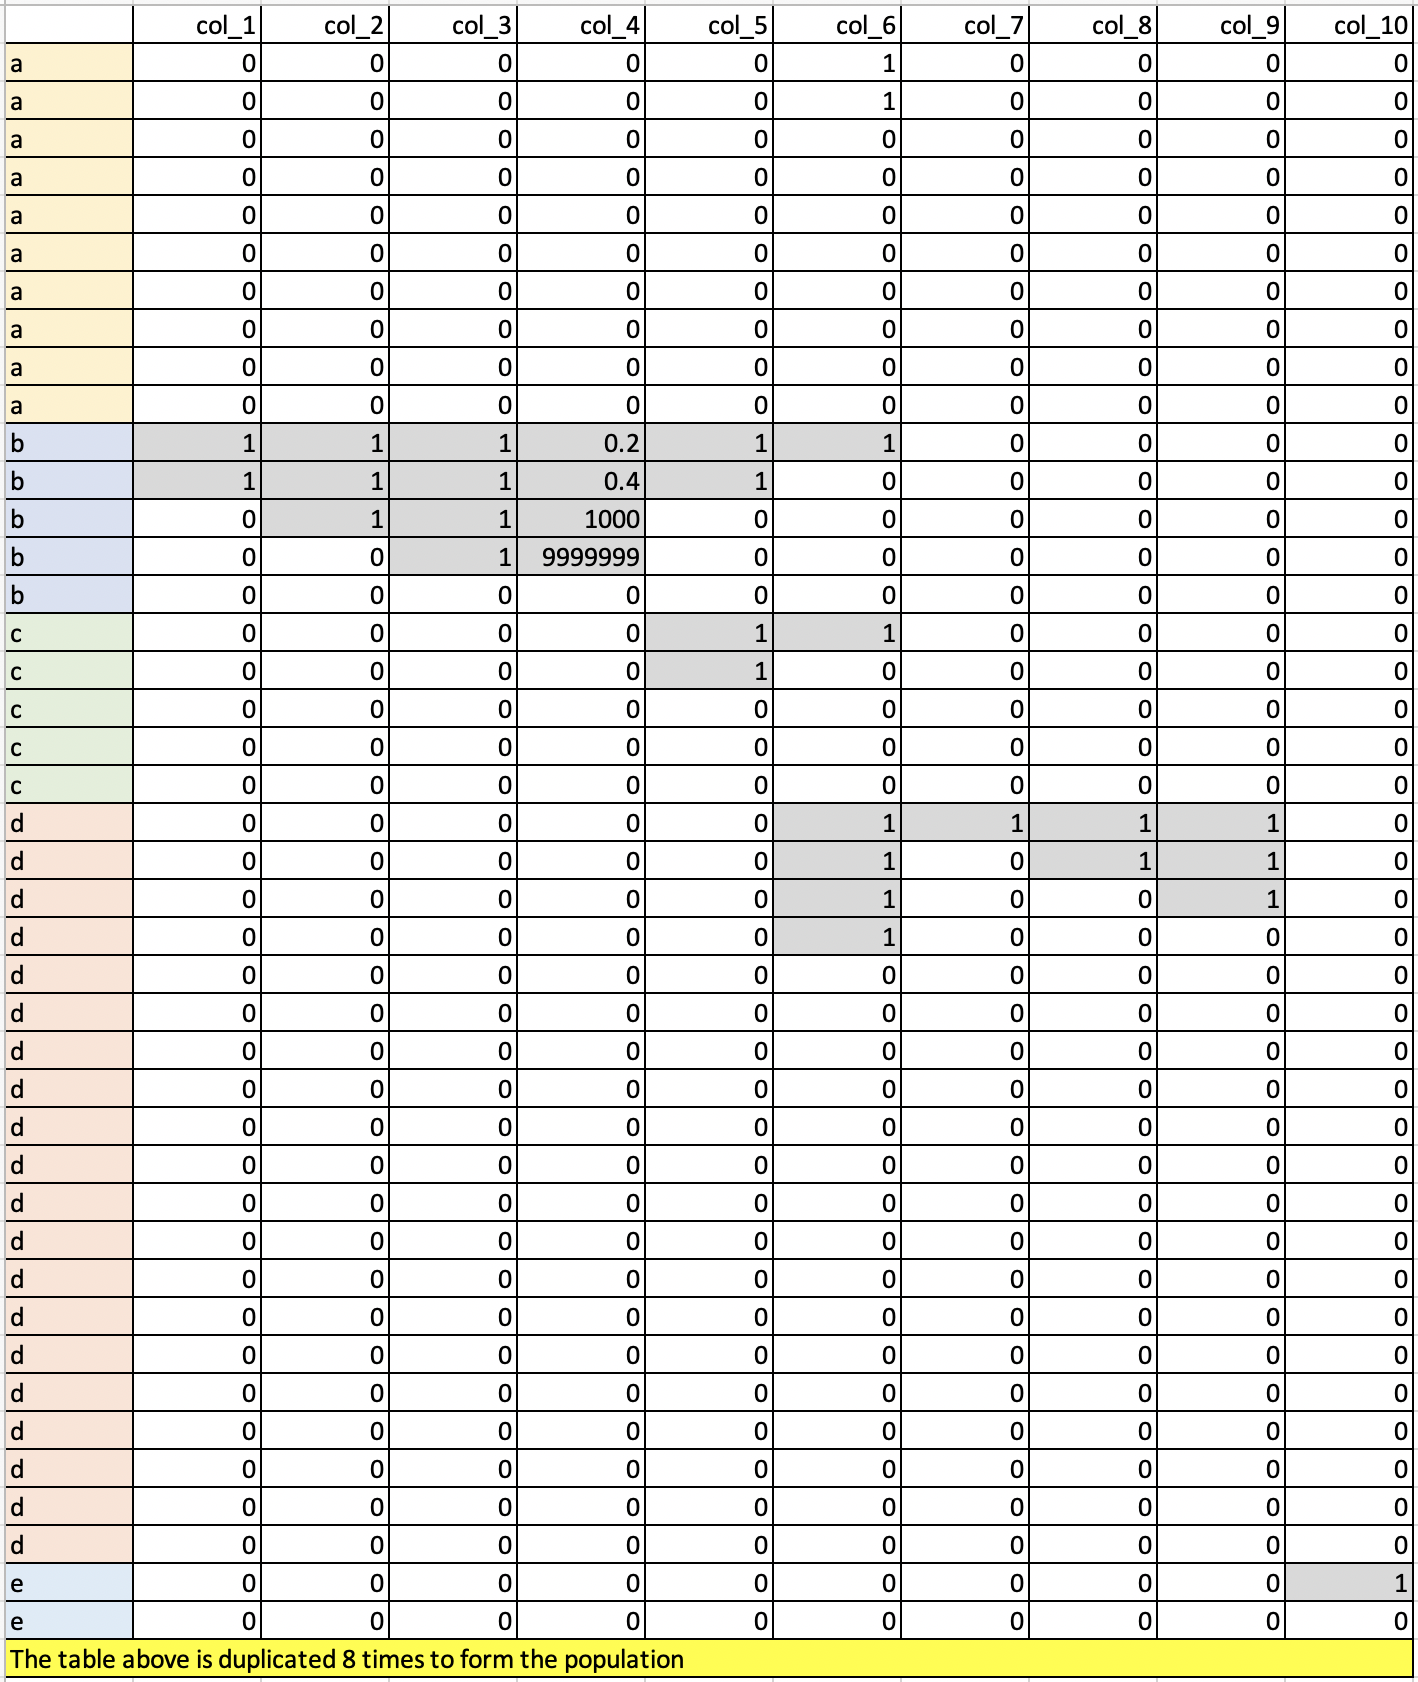

In [1]:
from IPython.display import Image
Image(filename="image/phik_test_data.png", width=700)

Phik values:

`col_1 0.50`, `col_2 0.62`, `col_3 0.75`, `col_4 0.34`, `col_5 0.47`, `col_6 0.0`, `col_7 0.10`, `col_8 0.17`, `col_9 0.22`, `col_10 0.57`

Conclusions:

- Phik generally makes sense and is a useful method for multiclass classification feature selection
- Scale of the value has an effect on phik value (see the underlying data for col_4)
- The generation of Significance has a random component in it, whereas the calculation of phik doesn’t (the same each time you run it)

In [ ]:
import pandas as pd
import phik
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

In [ ]:
df_test_phik = pd.read_csv("test_phik.csv")

In [ ]:
df_test_phik.phik_matrix(interval_cols=df_test_phik.columns.tolist()[1:], dropna=False).head(1)

In [ ]:
df_test_phik.significance_matrix(interval_cols=df_test_phik.columns.tolist()[1:], dropna=False).head(1)